In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%qtconsole
%config InlineBackend.figure_format = 'retina'

In [4]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import logging
logging.basicConfig(level=logging.INFO)

In [3]:
epoch_key = ('HPa', 6, 2)

In [25]:
from loren_frank_data_processing import make_neuron_dataframe, get_interpolated_position_dataframe
from src.parameters import ANIMALS, SAMPLING_FREQUENCY

neuron_info = make_neuron_dataframe(ANIMALS).xs(
    epoch_key, drop_level=False).query('numspikes > 0')

neuron_info

area       csi   meanrate  \
animal day epoch tetrode_number neuron_number                              
HPa    6   2     1              1               CA1  0.004049   0.409959   
                                2               CA1  0.117225   0.346888   
                                3               CA1  0.042945   0.405809   
                                4               CA1  0.104167   0.159336   
                                5               CA1  0.091950   2.247303   
                                6               CA1  0.093514   0.550207   
                 4              1               CA1  0.206349   0.156846   
                                2               CA1  0.088235   0.112863   
                                3               CA1  0.023166   0.214938   
                                4               CA1  0.151860   1.092946   
                                5               CA1  0.154930   0.235685   
                                6               CA1  0.047794   0.451452   
                 5              1               CA1  0.267584   0.542739   
                                2               CA1  0.097618   2.473859   
                                4               CA1  0.195122   0.544398   
                                5               CA1  0.069979   2.004149   
                 8              1              iCA1  0.048257   0.309544   
                 9              1              iCA1  0.087662   0.511203   
                 10             1              iCA1  0.067797   0.293776   
                 11             1              iCA1  0.139106   1.169295   
                 12             1              iCA1  0.032258   0.308714   
                 14             1              iCA1  0.087108   0.238174   
                 17             1               PFC  0.205399  56.261411   
                 18             1               PFC  0.006277   1.321992   

                                                       neuron_id  numspikes  \
animal day epoch tetrode_number neuron_number                                 
HPa    6   2     1              1              HPa_06_02_001_001      494.0   
                                2              HPa_06_02_001_002      418.0   
                                3              HPa_06_02_001_003      489.0   
                                4              HPa_06_02_001_004      192.0   
                                5              HPa_06_02_001_005     2708.0   
                                6              HPa_06_02_001_006      663.0   
                 4              1              HPa_06_02_004_001      189.0   
                                2              HPa_06_02_004_002      136.0   
                                3              HPa_06_02_004_003      259.0   
                                4              HPa_06_02_004_004     1317.0   
                                5              HPa_06_02_004_005      284.0   
                                6              HPa_06_02_004_006      544.0   
                 5              1              HPa_06_02_005_001      654.0   
                                2              HPa_06_02_005_002     2981.0   
                                4              HPa_06_02_005_004      656.0   
                                5              HPa_06_02_005_005     2415.0   
                 8              1              HPa_06_02_008_001      373.0   
                 9              1              HPa_06_02_009_001      616.0   
                 10             1              HPa_06_02_010_001      354.0   
                 11             1              HPa_06_02_011_001     1409.0   
                 12             1              HPa_06_02_012_001      372.0   
                 14             1              HPa_06_02_014_001      287.0   
                 17             1              HPa_06_02_017_001    67795.0   
                 18             1              HPa_06_02_018_001     1593.0   

               

In [7]:
from loren_frank_data_processing import get_interpolated_position_dataframe

position_info = get_interpolated_position_dataframe(epoch_key, ANIMALS)

ERROR:loren_frank_data_processing.core:Failed to load file: /Users/edeno/Documents/GitHub/Jadhav-2016-Data-Analysis/src/../Raw-Data/HPa_direct/HPaDIO06.mat
ERROR:loren_frank_data_processing.core:Failed to load file: /Users/edeno/Documents/GitHub/Jadhav-2016-Data-Analysis/src/../Raw-Data/HPa_direct/HPaDIO06.mat


In [60]:
from src.spike_models import get_position_knots
from patsy import dmatrices
from loren_frank_data_processing import get_spike_indicator_dataframe

neuron_key = ('HPa', 6, 2, 5, 2)

DROP_COLUMNS = ['from_well', 'to_well', 'labeled_segments']

spikes = get_spike_indicator_dataframe(
    neuron_key, ANIMALS).rename('is_spike')
data = (position_info.join(spikes)
        .drop(DROP_COLUMNS, axis=1)
        .dropna())
x_knots, y_knots = get_position_knots(neuron_key[:-2], ANIMALS, knot_spacing=15)
formula = ('is_spike ~ 1 + te(cr(x_position, knots=x_knots), '
           'cr(y_position, knots=y_knots), constraints="center")')

is_spike, design_matrix = dmatrices(formula, data, return_type='dataframe')

In [61]:
from src.spike_models import fit_glm

penalty = 1E1
fit = fit_glm(is_spike, design_matrix, penalty)

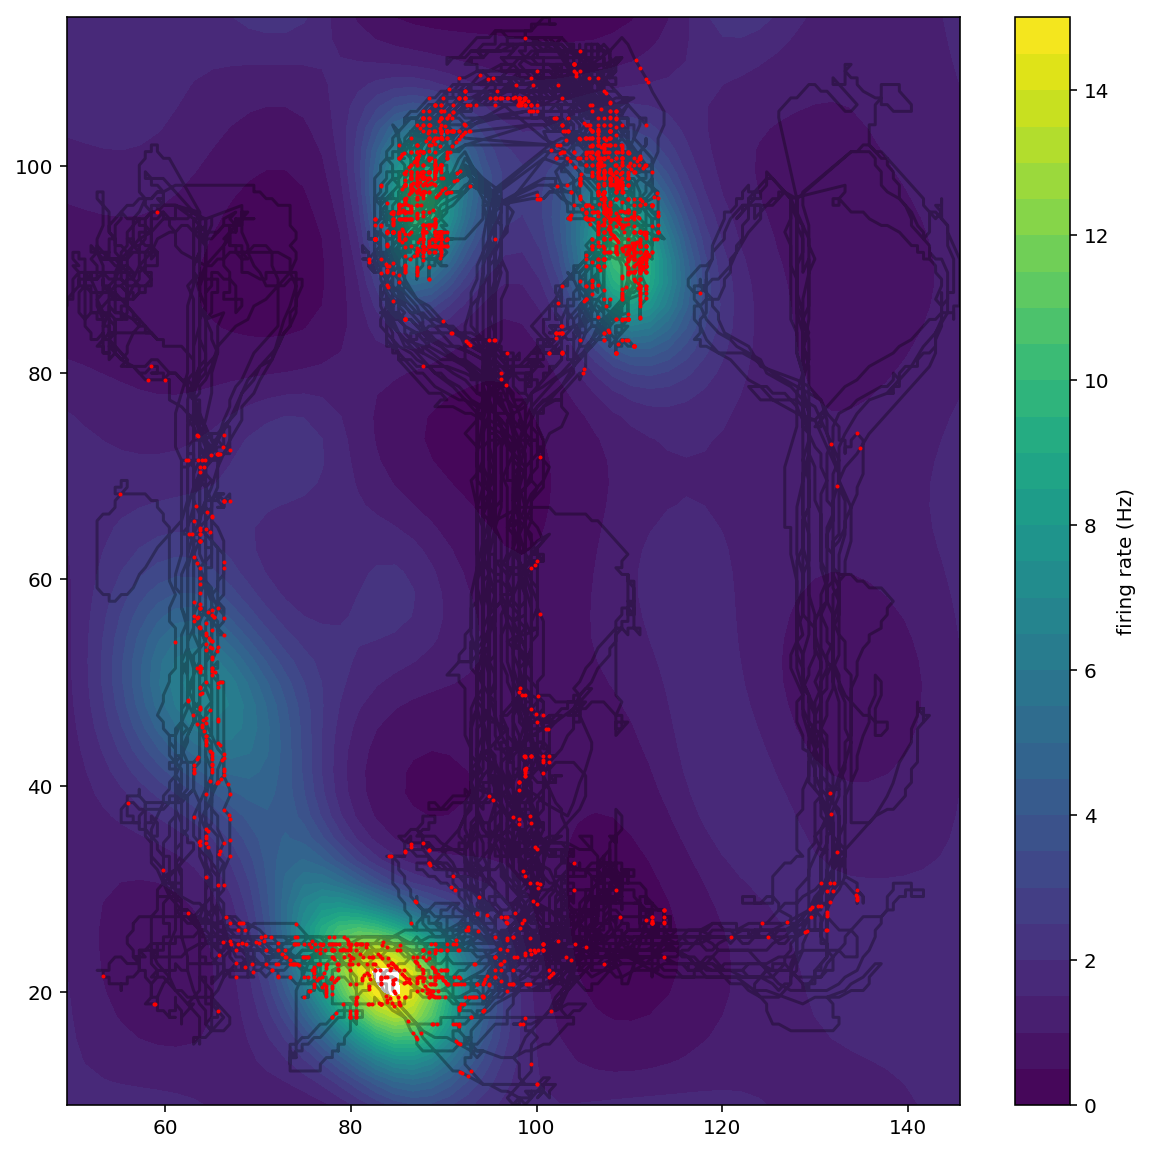

In [62]:
from patsy import build_design_matrices

x = np.linspace(data.x_position.min(), data.x_position.max(), 50)
y = np.linspace(data.y_position.min(), data.y_position.max(), 50)
x, y = np.meshgrid(x, y)

predict_data = {'x_position': x.ravel(), 'y_position': y.ravel()}
predict_design_matrix = build_design_matrices(
    [design_matrix.design_info], predict_data)[0]

firing_rate = (np.exp(predict_design_matrix @ fit.coefficients)
               * SAMPLING_FREQUENCY).reshape(x.shape)
max_rate = np.round(np.max(firing_rate), decimals=2)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
mappable = ax.contourf(x, y, firing_rate, np.arange(0, max_rate, .5));
plt.colorbar(mappable, ax=ax, label='firing rate (Hz)')
plt.plot(data.x_position, data.y_position, alpha=0.3, color='black')
plt.scatter(data.query('is_spike == 1').x_position, data.query('is_spike == 1').y_position,
            s=1, zorder=100, color='red')

In [87]:
from src.spike_models import fit_2D_position

fit = fit_2D_position(neuron_key, ANIMALS, SAMPLING_FREQUENCY, position_info, penalty)

INFO:src.spike_models:Fitting 2D position model for ('HPa', 6, 2, 5, 2)


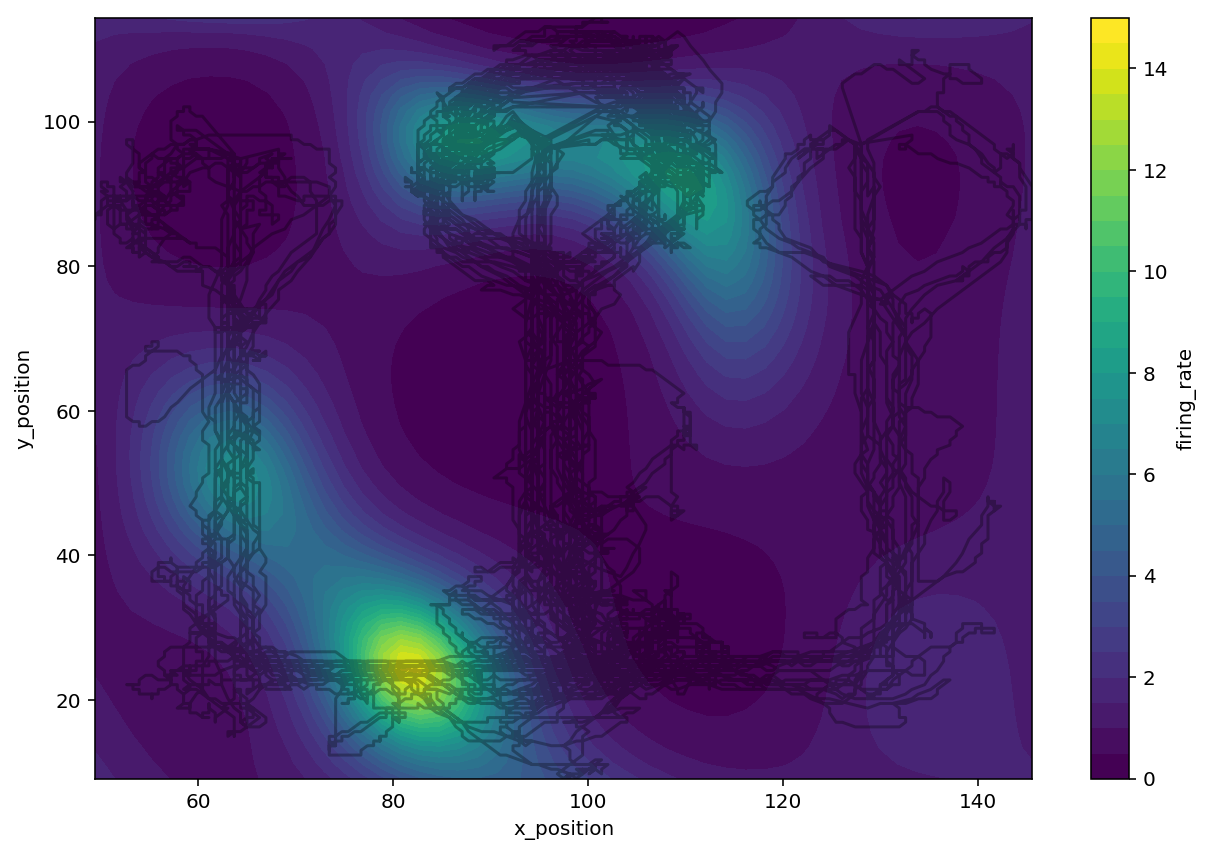

In [95]:
h = fit.firing_rate.plot.contourf(x='x_position', y='y_position', size=7,
                              levels=np.arange(0, max_rate, .5))
h.ax.plot(data.x_position, data.y_position, alpha=0.3, color='black')

In [63]:
from src.spike_models import fit_2D_position_by_task

fit_by_task = fit_2D_position_by_task(neuron_key, ANIMALS, SAMPLING_FREQUENCY, position_info, penalty)

INFO:src.spike_models:Fitting 2D position model by task for ('HPa', 6, 2, 5, 2)


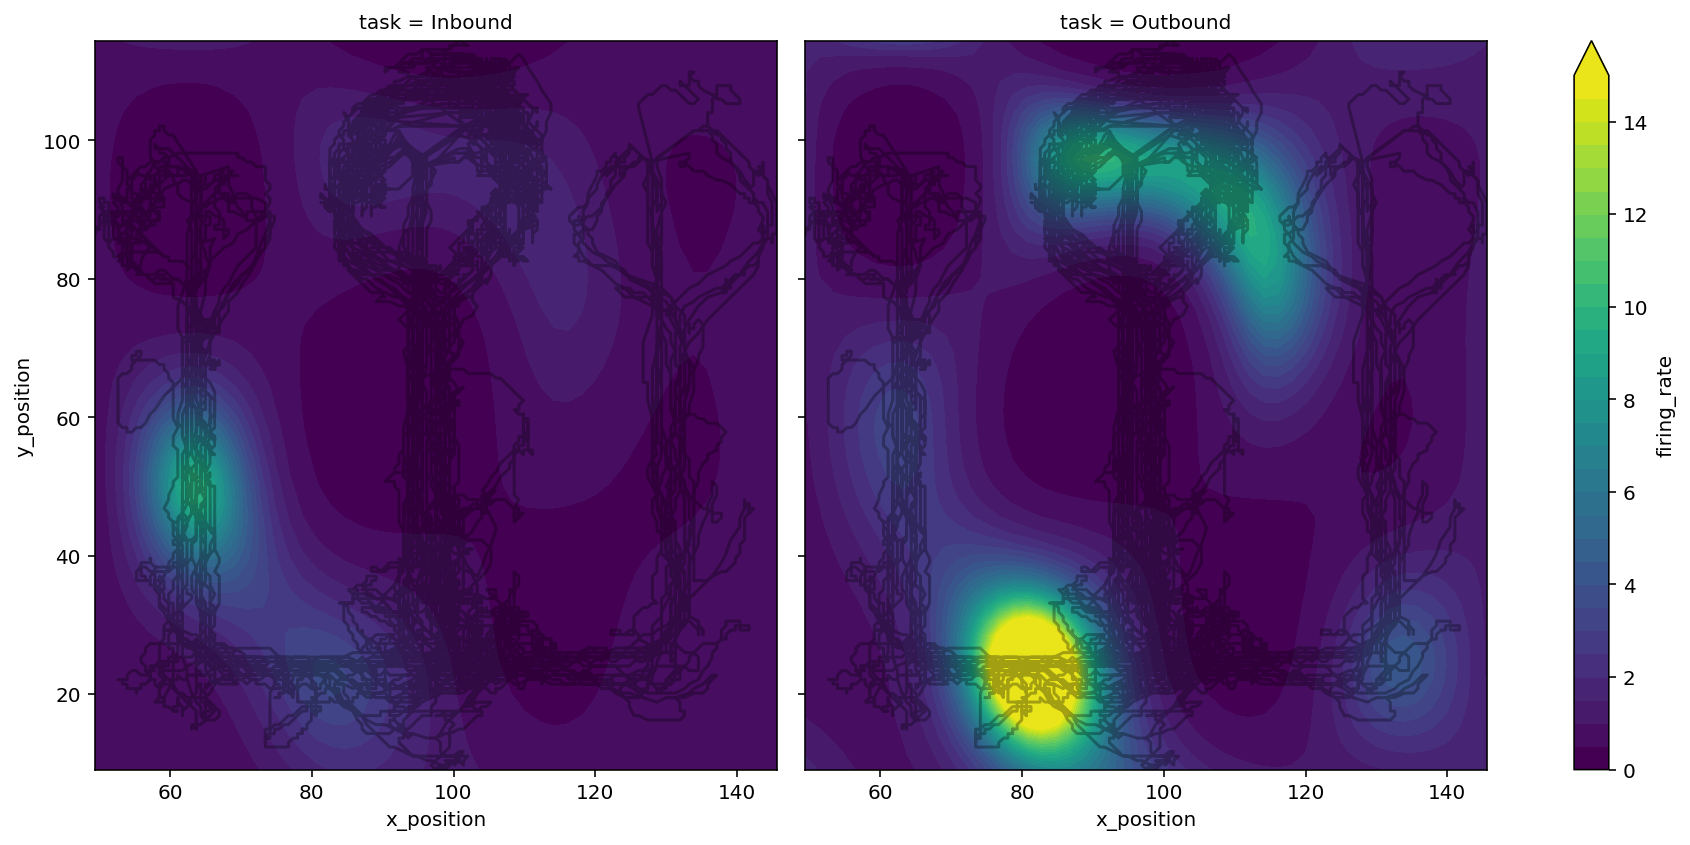

In [82]:
h = fit_by_task.firing_rate.plot.contourf(x='x_position', y='y_position', col='task', size=6,
                                          levels=np.arange(0, max_rate, .5))
for ax in h.axes.flat:
    ax.plot(data.x_position, data.y_position, alpha=0.3, color='black')

In [78]:
from src.spike_models import fit_2D_position_by_speed

fit_by_speed = fit_2D_position_by_speed(neuron_key, ANIMALS, SAMPLING_FREQUENCY, position_info, penalty)

INFO:src.spike_models:Fitting 2D position and speed model for ('HPa', 6, 2, 5, 2)


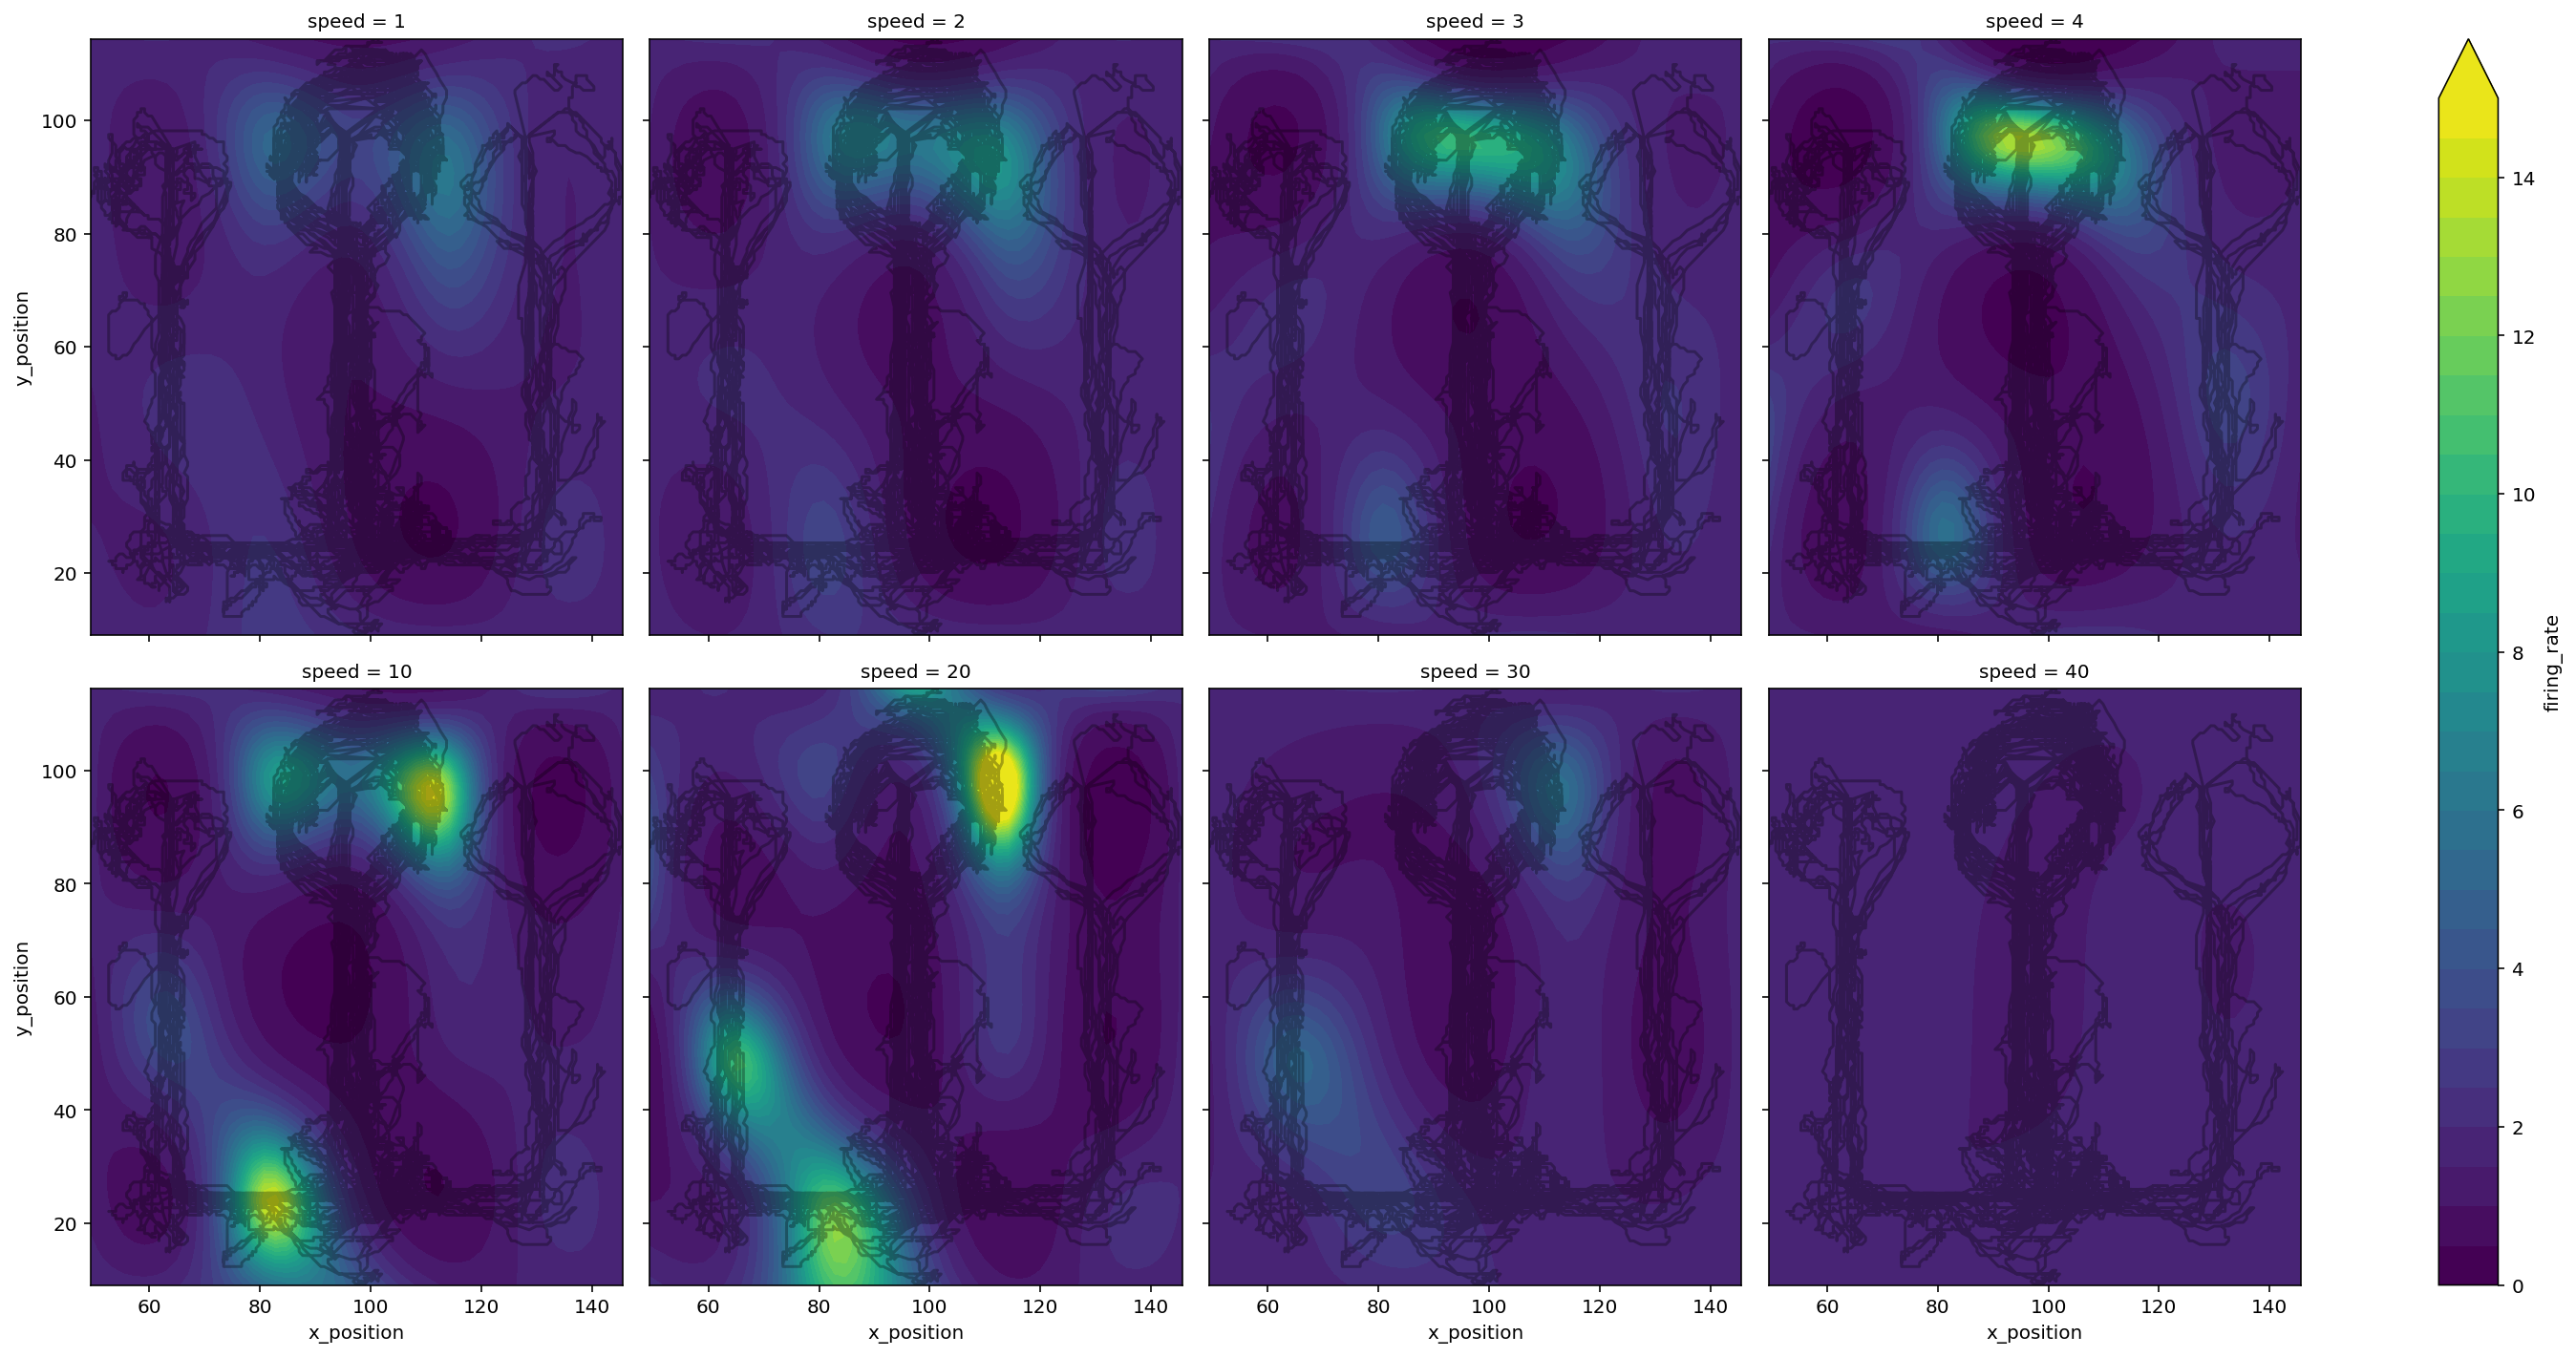

In [84]:
h = fit_by_speed.firing_rate.plot.contourf(
    x='x_position', y='y_position', col='speed', col_wrap=4,
    levels=np.arange(0, max_rate, .5), size=5)

for ax in h.axes.flat:
    ax.plot(data.x_position, data.y_position, alpha=0.3, color='black')

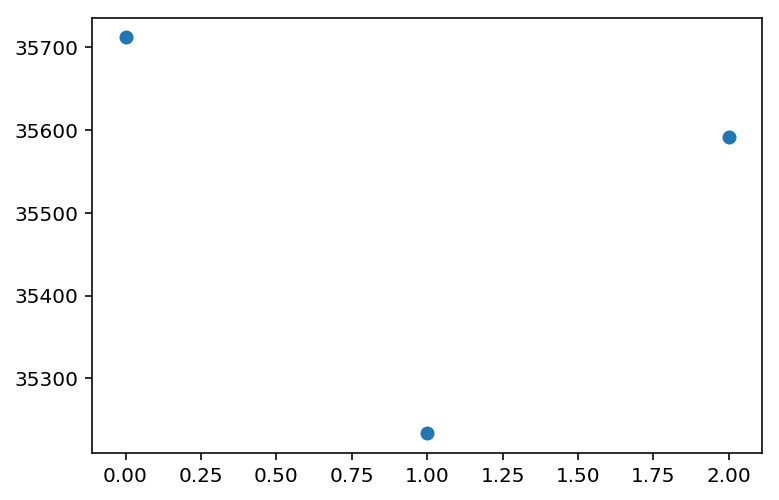

In [101]:
plt.scatter(np.arange(3), [fit.AIC, fit_by_task.AIC, fit_by_speed.AIC])